# Isolated fiber nodes - analysis of membrane dynamics upon electrical stimulation

Here we wish to analyze the membrane dynamics of several models used to represented myelinated fibers (Sweeney & FrankenHaeuser-Huxley), in order to explain the different behavioral regimes observed across a range of characteristic stimulus amplitudes.

### Imports

In [5]:
import logging
import numpy as np
import matplotlib.pyplot as plt

from PySONIC.core import PulsedProtocol, ElectricDrive
from PySONIC.neurons import getPointNeuron
from PySONIC.utils import logger, si_format
from PySONIC.plt import CompTimeSeries, GroupedTimeSeries

### Setup

Let's define functions to explore behavioral regimes and details of membrane dynamics.

In [2]:
logger.setLevel(logging.WARNING)

def plotResponses(pneuron, pp, rel_Irange):
    ''' Compute a model's excitation threshold and plot membrane potential traces
        for a range of relative amplitudes w.r.t. the computed threshold. 
    '''
    Ithr = pneuron.titrate(ElectricDrive(None), pp)  # mA/m2
    print(f'Ithr = {si_format(Ithr * 1e-3, 2)}A/m2')
    outputs = [pneuron.simulate(ElectricDrive(x * Ithr), pp) for x in rel_Irange]
    return CompTimeSeries(outputs, 'Vm').render(labels=[f'{x:.1f} Ithr' for x in rel_Irange])

def plotResponseDetails(pneuron, pp, Idrive):
    ''' Plot the model's detailed membrane dynamics for a given stimulus amplitude,
        including gating variables.
    '''
    data, meta = pneuron.simulate(ElectricDrive(Idrive), pp)
    return GroupedTimeSeries([(data, meta)]).render()


# Sweeney model

We first focus on the Sweeney model that depicts membrane dynamics at the Ranvier nodes of myelinated fibers in mammals (rabbits). This model is a good starting point as it presents the simplest form of membrane dynamics, composed only of fast Sodium and leakage currents (i.e. **no Potassium currents**).

### Typical responses

Let's analyze the evolution of voltage responses for a range of characteristic input currents:

Ithr = 14.34 A/m2


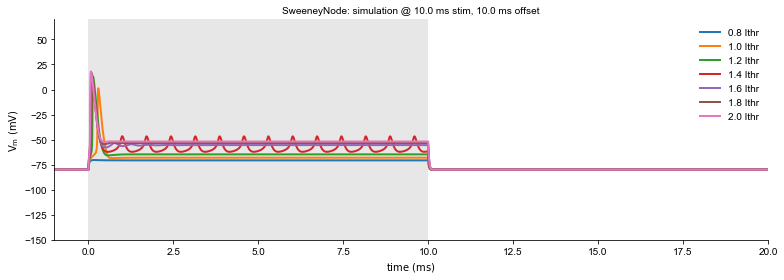

In [3]:
pneuron = getPointNeuron('SW')
pp = PulsedProtocol(10e-3, 10e-3)
fig = plotResponses(pneuron, pp, np.linspace(0.8, 2, 7))

The model's excitation threshold for this pulse duration is 14.3 A/m2.

Moreover, we can distinguish 3 active regimes that differ mostly by their behavior following the occurrence of a first spike:
- **Low plateau potential regime:** single spike followed by voltage stabilization slightly above the resting potential.
- **Sustained oscillatory regime:** single spike followed by periodic oscillations slightly above the resting potential.
- **High plateau potential regime:** single spike followed by voltage stabilization at a plateau potential significantly above the resting potential.

These regimes are obtained for stimulus amplitudes ranging from just above to twice the excitation threshold. Let's look at them more in details.

### Low plateau potential regime

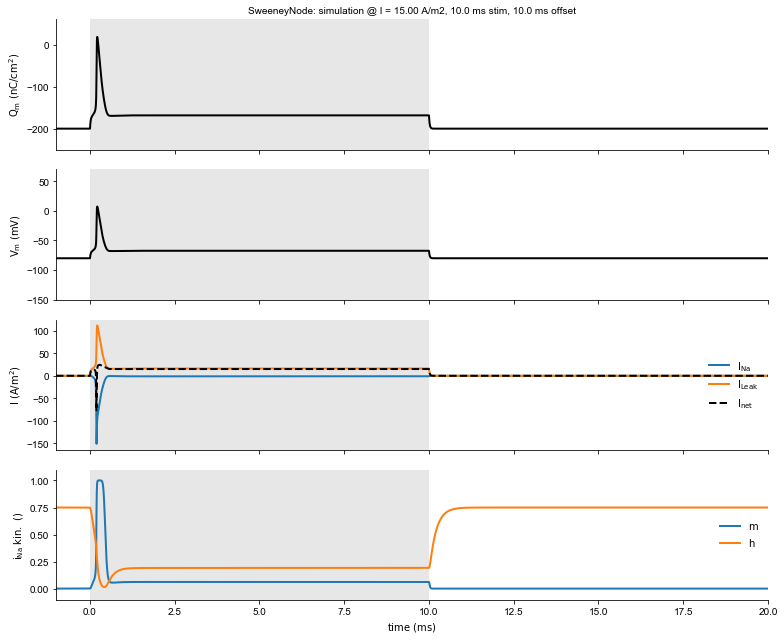

In [4]:
fig = plotResponseDetails(pneuron, pp, 15e3)

- At rest, the Sodium m-gate is closed while h-gate is significantly opened.
- Upon stimulation, membrane depolarization triggers a fast m-gate opening and slow h-gate closing, creating a significant Sodium transient that triggers a full depolarization.
- Upon h-gate closure, Sodium current vanishes and the membrane repolarizes.
- Eventually, the membrane stabilizes at a steady-state voltage slightly higher than the resting potential, where leakage and injected currents balance out.
- This incomplete repolarization prevents full h-gate re-opening while keeping the h-gate almost fully closed. This significantly limits the Sodium current amplitude for the rest of the stimulus, hence no subsequent AP is fired.

### Sustained oscillatory regime

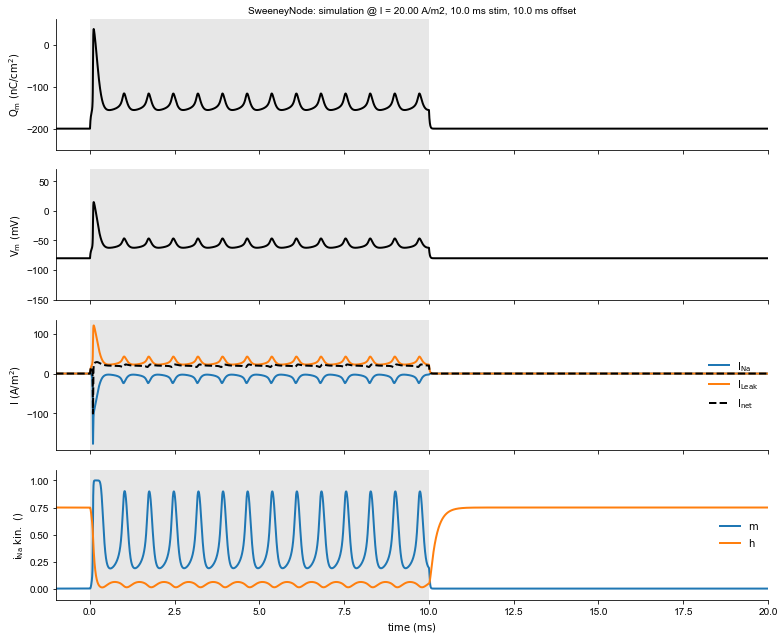

In [5]:
fig = plotResponseDetails(pneuron, pp, 20e3)

- AP dynamics is similar, but due to the stronger stimulus, currents balance occurs at a slightly higher voltage upon membrane repolarization. 
- As a result, Sodium m-gate does not close entirely while h-gate stays slightly open, which gives rise to another transient Sodium current.
- Incomplete repolarization prevents full h-gate re-opening, hence the Sodium current transient cannot produce a full depolarization, and the membrane starts repolarizing as the h-gate closes.
- The process is repeated periodically until the stimulus offset.

### High plateau potential regime

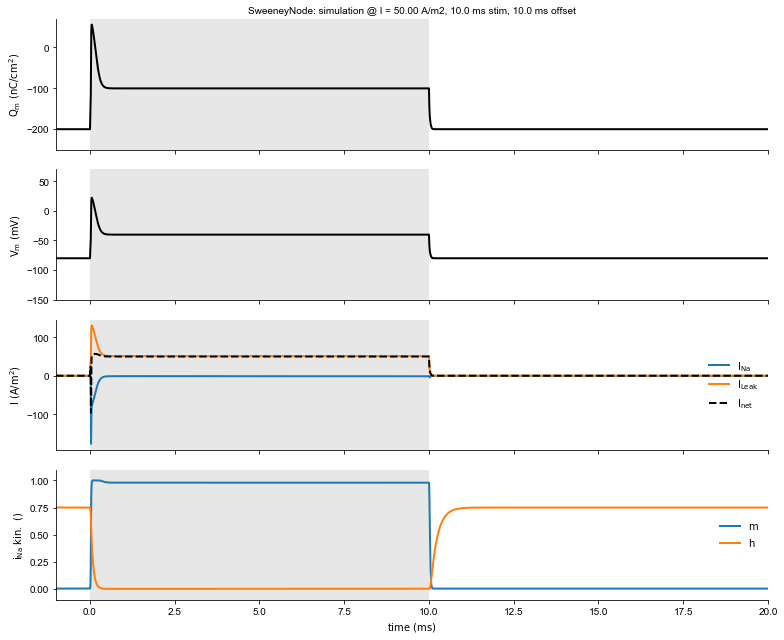

In [6]:
fig = plotResponseDetails(pneuron, pp, 50e3)

- AP dynamics is similar, but due to the even stronger stimulus, currents balance occurs at an even higher voltage upon membrane repolarization. 
- As a result, Sodium m-gate stays significantly open but h-gate closes almost completely, and the resulting Sodium current is too small to cause significant depolarization.
- Eventually, the membrane potential stabilizes at where leakage and injected currents balance out.

Expectedly, the final steady-state voltage evolves towards more depolarized values as the injected current increases in amplitude.

### Conclusions

- The Sweeney model shows 3 active behavioral regimes, all of which characterized by a single spike response.
- The presence of sustained voltage oscillations after the first spike at intermediate stimulus amplitudes is mediated by transient windows of simultaneous opening of the Sodium gates.
- Such a window cannot be reached for weaker stimuli (where the m-gate stays closed) and stronger stimuli (where the h-gate does not re-open).

# Frankenhaeuser-Huxley model

We now focus on the FH model that was first derived to depict membrane dynamics at the Ranvier nodes of myelinated fibers in amphibians (frogs). Despite being older than the Sweeney counterpart, this model contains a more complex membrane dynamics with fast Sodium, fast Potassium, non-specific delayed, and leakage currents.

### Typical responses

Let's analyze the evolution of voltage responses for a range of characteristic input currents:

Ithr = 3.39 A/m2


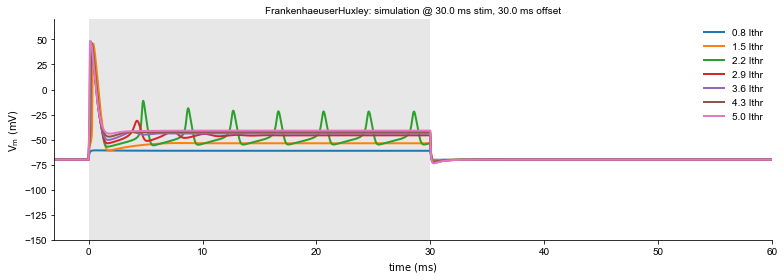

In [7]:
pneuron = getPointNeuron('FH')
pp = PulsedProtocol(30e-3, 30e-3)
fig = plotResponses(pneuron, pp, np.linspace(0.8, 5, 7))

The FH model displays similar behavioral regimes as the Sweeney model, although we notice significant quantitative differences:
- The FH model's excitation threshold for this pulse duration is about 3.4 A/m2, i.e. about 4 times lower than for the Sweeney model. This is a result of the model's weaker leakage conductance (also by a factor 4), offering less resistance to injected currents and thereby facilitating the reach of the spiking threshold.
- The different behavioral regimes occur over a wider amplitude range, spreading from just above to five times the excitation threshold.
- Across all behavioral regimes, the membrane dynamics is significantly slower than for the Sweeney model.

Let's look at these regimes more in details.

### Low plateau potential regime

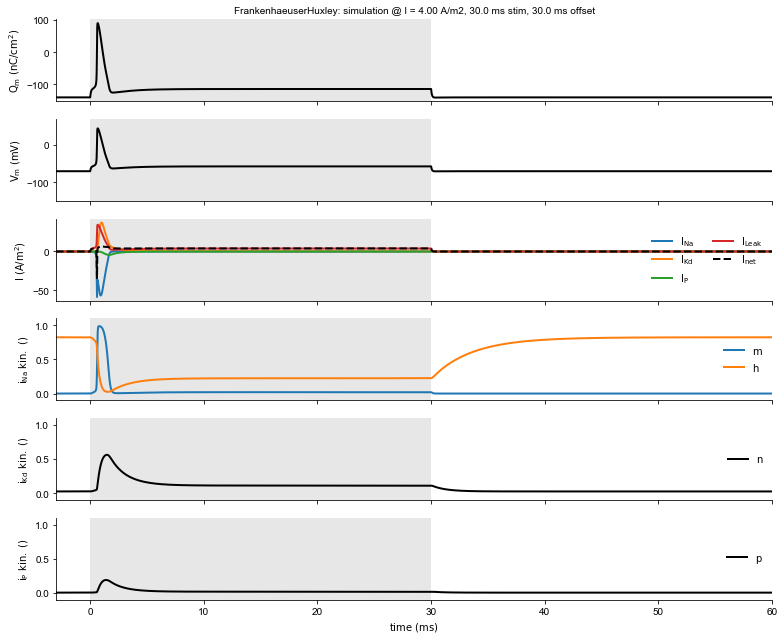

In [8]:
fig = plotResponseDetails(pneuron, pp, 4e3)

The membrane dynamics is highly similar to that of the Sweeney model, with the additional presence of Potassium currents that further control repolarization:
- At rest, the Sodium m-gate is closed while h-gate is significantly opened. Both fast and slow Potassium gates are closed
- Upon stimulation, membrane depolarization triggers a fast m-gate opening and slow h-gate closing, creating a significant Sodium transient that triggers a full depolarization.
- Progressive potassium n-gate opening triggers an outward Potassium current that repolarizizes the membrane despite some residual Sodium current.
- Eventually, the membrane stabilizes at a steady-state voltage slightly higher than the resting potential, where membrane and injected currents balance out.
- This partial repolarization prevents full h-gate re-opening, which significantly limits the Sodium current amplitude for the rest of the stimulus, hence no subsequent AP is fired.

### Sustained oscillatory regime

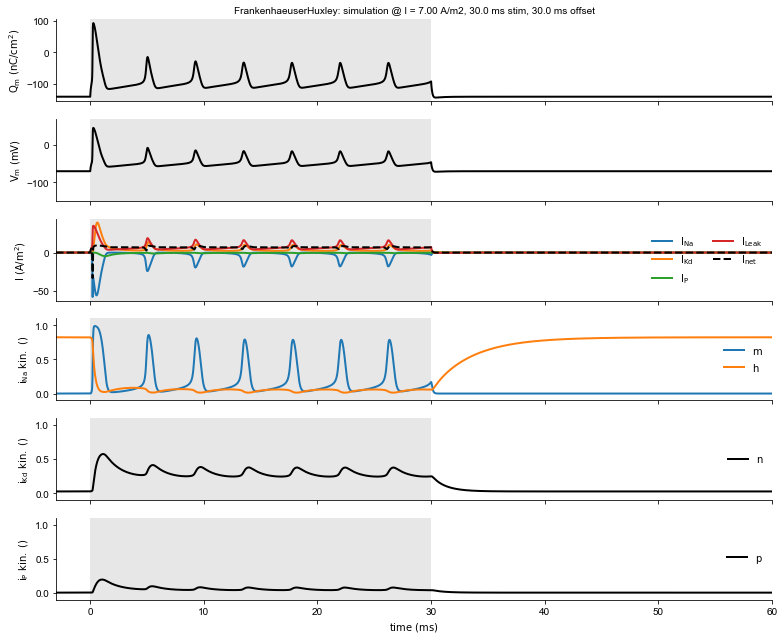

In [9]:
fig = plotResponseDetails(pneuron, pp, 7e3)

Again, we observe a similar dynamics as for the Sweeney model: the stronger stimulus disrupts the currents balance upon repolarization to a slightly higher voltage, for which both Sodium gates can be slightly opened and give rise to subsequent Sodium transients in a periodic manner.

Moreover, this behavior is also obtained after suppressing Potassium currents from the model. Thus, it seems that the periodic oscillations following the first AP in this intermediate regime are primarily mediated by the Sodium current.

### High plateau potential regime

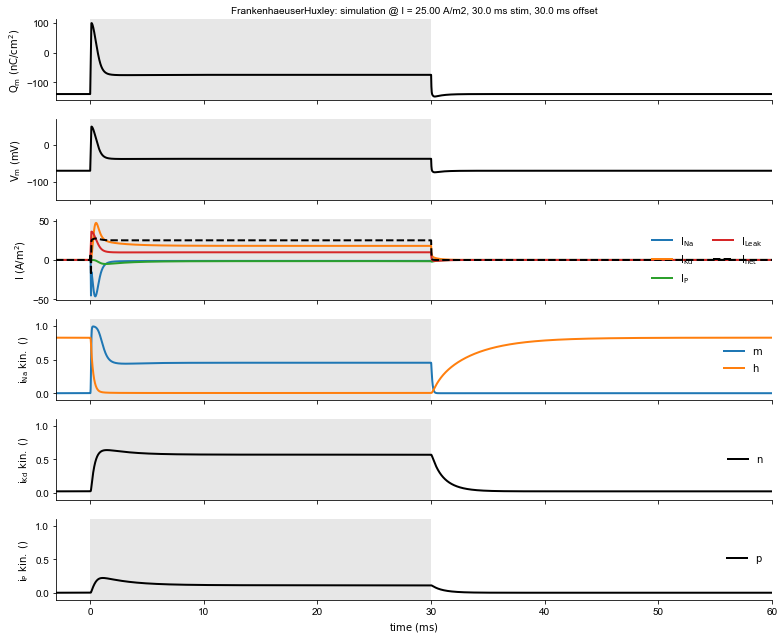

In [10]:
fig = plotResponseDetails(pneuron, pp, 25e3)

Here again, we observe a similar dynamics as with the Sweeney model: the stimulus increase further disrupts the currents balance upon repolarization to an even higher voltage, at which the Sodium h-gate stays almost completely closed, thereby further limiting the resulting Sodium current and not causing any subsequent depolarization.

Moreover, the final steady-state voltage value also increases with the stimulus amplitude.

### Conclusions

- The FH model also shows 3 active behavioral regimes, all of which characterized by a single spike response.
- Sodium transients also mediate sustained post-spike oscillations at intermediate stimulus amplitudes, 
- The presence of Potassium currents offers more resistance to subsequent depolarizations after the first spike, thereby expanding the range of amplitudes at which the neuron transitions between different active regimes.

# Sundt model

We now focus on the Sundt model that was derived to depict membrane dynamics of unmyelinated fibers in mammals. This model has a relatively simple membrane dynamics, composed of fast Sodium, fast Potassium, and leakage currents.

### Typical responses

Let's analyze the evolution of voltage responses for a bunch of characteristic input currents:

Ithr = 6.25 mA/m2


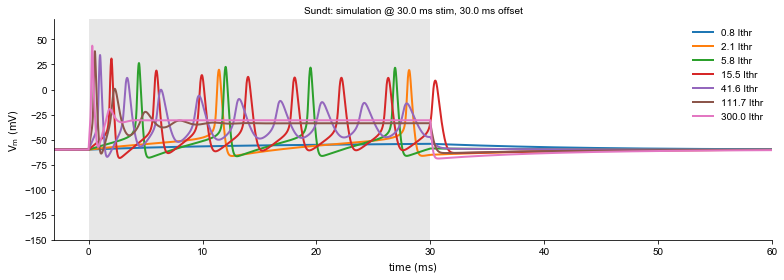

In [11]:
pneuron = getPointNeuron('sundt')
pp = PulsedProtocol(30e-3, 30e-3)
fig = plotResponses(pneuron, pp, np.logspace(np.log10(0.8), np.log10(3e2), 7))

The Sundt model displays somewhat similar behavioral regimes as the FH and Sweeney models. However, we notice major quantitative and qualitative differences w.r.t its myelinated counterparts:
- The Sundt model has an excitation threshold around 6.2 mA/m2, i.e. 3 orders of magnitude lower than the Sweeney and FH models (!!!). This is the result of a much weaker leakage conductance.
- Right above the excitation threshold, the low plateau potential regime is replaced by a **sustained firing regime** in which spikes are fired in a periodic manner.
- The different behavioral regimes occur over an even wider, logarithmic amplitude range, spreading from just above to more than 100 times the excitation threshold.

Let's look at these regimes more in details.

### Sustained firing regime

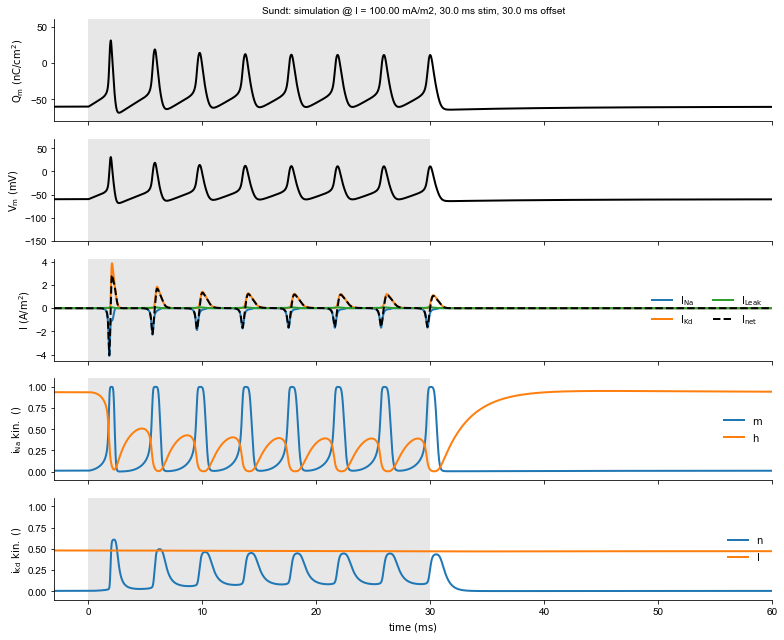

In [12]:
fig = plotResponseDetails(pneuron, pp, 100.)

The membrane dynamics is somewhat similar to those of the FH and Sweeney models, with a much weaker leakage conductance that indirectly permits repetitive firing:
- At rest, the Sodium m-gate is closed while h-gate is significantly opened. The Sodium n-gate is closed while its l-gate is half-way opened.
- Upon application of a small current, the weak leakage conductance does not offer significant resistance to depolarization, hence the spiking threshold can be easily reached.
- Once the spiking threshold is reached, fast m-gate opening and slow h-gate closing create a significant Sodium transient that triggers a full depolarization.
- Progressive potassium n-gate opening triggers an outward Potassium current that repolarizizes the membrane despite some residual Sodium current.
- The relatively high amplitude of Potassium current w.r.t. the injected current allows for complete repolarization
- This complete repolarization allows for significant Sodium h-gate re-opening, and hence the Sodium channel can trigger a subsequent AP once the spiking threshold has been reached again.

### Sustained oscillatory regime

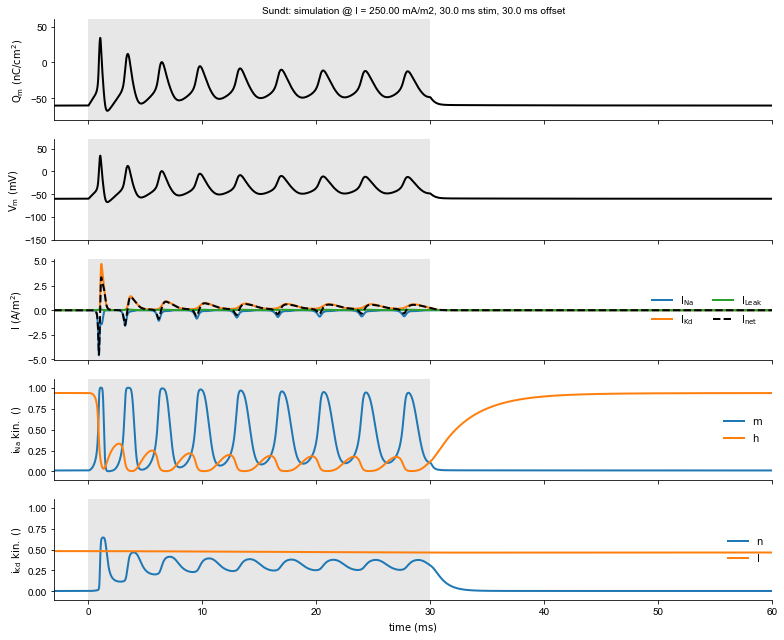

In [13]:
fig = plotResponseDetails(pneuron, pp, 250.)

Here, the membrane dynamics is strikingly different than for myelinated models:  
- The stronger stimulus induces a faster depolarization after the first spike, which does not give enough time for a significant Sodium h-gate re-opening. 
- Hence, the subsequent Sodium transient is weaker and does not permit full depolarization, resulting in an attenuated spike amplitude.
- This attenuated depolarization limits the Potassium n-gate opening, which limits the subsequent repolarization and hence also the Sodium h-gate opening, resulting in an even weaker subsequent spike.
- Eventually, a limit cycle is reached with voltage oscillations of attenuated amplitude.

### High plateau potential regime

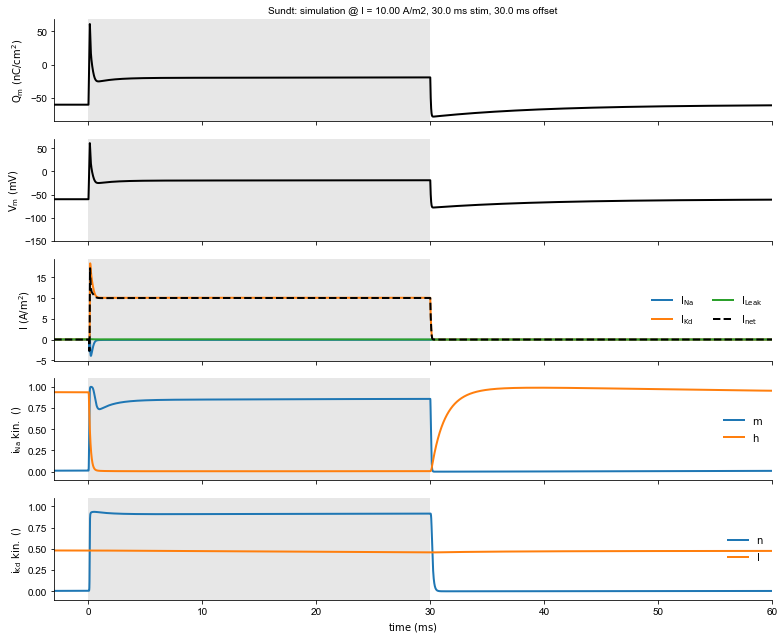

In [14]:
fig = plotResponseDetails(pneuron, pp, 1e4)

Here, we observe a similar dynamics as with the Sweeney and FH models: the stimulus increase further disrupts the currents balance upon repolarization to an even higher voltage, at which the Sodium h-gate closes almost completely, thereby further limiting the resulting Sodium current and not causing any subsequent depolarization.

Eventually, the final steady-state voltage value also starts increasing if we further increase the stimulus amplitude by several orders of magnitude.

### Conclusions

The Sundt model has a much weaker conductance than its myelinated counterparts. This has 3 major implications:
- By offering far less resistance to injected currents, it allows for excitation at drastically lower thresholds.
- Consequently, amplitudes just above the excitation threshold allow for complete repolarization and permit sustained periodic firing.
- This also means that a wider range of stimulus amplitudes must be explored before reaching a high plateau potential regime, as the latter is dependent on a relative repolarization blocking and subsequent locking of the Sodium h-gate in a closed state.

Nevertheless, we also notice some similitudes, such as the presence of post-spike oscillations at intermediate stimulus amplitudes mediated by Sodium transients, and the presence of a high plateau potential regime upon injection of strong currents.

# MRG model

We now focus on the MRG (McIntyre, Richardson & Grill) model that was derived to depict the nodal membrane dynamics of mammalian myelinated fibers. This model differs from the previous ones as it is usually embedded into a double-cable fiber model (as opposed to single cable). Yet, it has a relatively simple membrane dynamics, composed of fast Sodium, persistent Sodium, slow Potassium, and leakage currents.

### Typical responses

Let's analyze the evolution of voltage responses for a bunch of characteristic input currents:

Ithr = 179.00 mA/m2


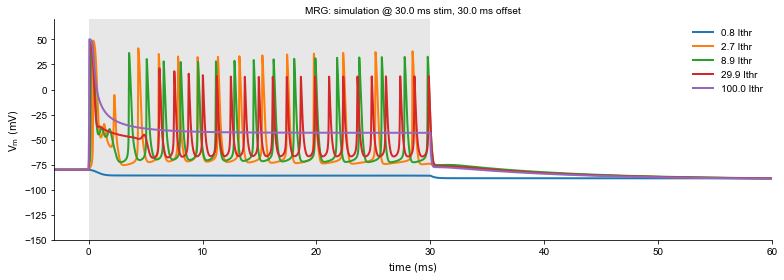

In [15]:
pneuron = getPointNeuron('MRG')
pp = PulsedProtocol(30e-3, 30e-3)
fig = plotResponses(pneuron, pp, np.logspace(np.log10(0.8), np.log10(1e2), 5))

The MRG model displays ...

# TO BE CONTINUED...

Let's look at these regimes more in details.

# General conclusions

Across these models, the magnitude of leakage conductance seems to be crucial in their determining their firing ability:
- A weak leakage conductance allows for excitation at low thresholds, which indirectly allows for full repolarization by Potassium currents in the supra-threshold regime, thereby permitting Sodium channels "resetting" and repetitive firing.
- A strong leakage conductance only allows for excitation at higher thresholds, at which the injected current then dominates over the Potassium currents and prevents full repolarization in the supra-threshold regime, thereby preventing Sodium channels "resetting" and silencing the neuron after a single spike.


## COMPARISON WITH LITERATURE???

# Comparative strength-duration curves

In [3]:
durations = np.logspace(-5, 0, 30)
offset = 10e-3
drive = ElectricDrive(None)
pps = [PulsedProtocol(t, offset) for t in durations]
pneurons = [getPointNeuron(k) for k in ['SW', 'FH', 'sundt', 'MRG']]
Ithrs = {pneuron.name: np.array([pneuron.titrate(drive, pp) for pp in pps]) for pneuron in pneurons}  # mA/m2

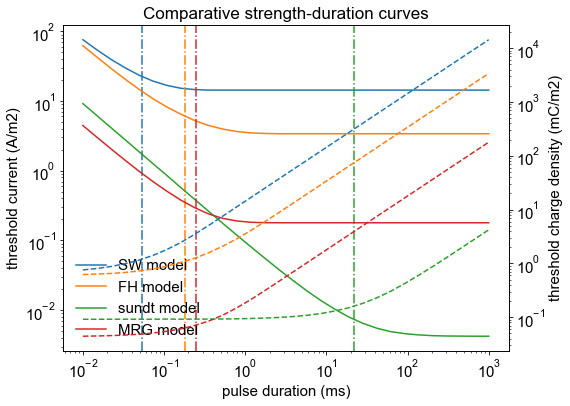

In [6]:
def plotSDcurves(Ithrs, durations, fs=15):
    ''' Plot a strength-duration curves of various models for a range of stimulus durations. '''
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title('Comparative strength-duration curves', fontsize=fs + 2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('pulse duration (ms)', fontsize=fs)
    ax.set_ylabel('threshold current (A/m2)', fontsize=fs)
    ax2 = ax.twinx()
    ax2.set_yscale('log')
    ax2.set_ylabel('threshold charge density (mC/m2)', fontsize=fs)
    for item in ax.get_xticklabels() + ax.get_yticklabels() + ax2.get_yticklabels():
        item.set_fontsize(fs)
    for i, (k, v) in enumerate(Ithrs.items()):
        color = f'C{i}'
        ax.plot(durations * 1e3, v * 1e-3, c=color, label=f'{k} model')
        ax2.plot(durations * 1e3, v * durations, '--', c=color, label=f'{k} model')
        Irh, Qrh = min(v), min(v * durations)
        tau = Qrh / Irh
        ax.axvline(tau * 1e3, linestyle='-.', c=color)
    ax.legend(frameon=False, fontsize=fs)
    return fig

fig = plotSDcurves(Ithrs, durations)

As we can see, all models show a typical SD dependency: excitation thresholds are high for short pulses, then decrease as stimulus duration increases and finally stabilize around an asymptotical value (so called rheobase current) for long enough pulses. The opposite behavior is observed for the dependency on charge density.

Nonetheless, we notice important qualitative differences:
- The Sweeney model has a rheobase charge around 1 mC/m2, a rehobase current around 14 A/m2 and an SD time constant around 50 us
- The FH model converges towards a similar value of rheobase charge, but has a smaller rheobase current (around 3.4 A/m2) and a longer SD time constant (around 200 us)
- The Sundt model has a lower rheobase charge (around 0.1 mC/m2) and drastically lower rheobase current (around 5 mA/m2), and a significantly longer than SD time constant (around 20 ms)